<a href="https://colab.research.google.com/github/MikelBarajas38/MachineLearning/blob/main/ClassCompFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Comparative Analysis of Classifier Models**

## Machine Learning
### Mikel Ignacio Barajas Martínez

Ingeniería en Sistemas Inteligentes, 2021, 336483, 202102300012 \
Machine Learning, 281601

### 03/31/24

𝝮


In [ ]:
# base imports
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# data preparation and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# metrics and evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# decision tree
from sklearn import tree

# naive bayes
from sklearn.naive_bayes import GaussianNB

# k-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.inspection import DecisionBoundaryDisplay # visualization

# SVMs
from sklearn import svm
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from matplotlib.colors import Normalize

# DNNs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# CNNs
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

## **Abstract**

This notebook presents a comparative analysis between three simple classifier models: decision trees, which generate “rules” based on the relationship between
the input data (using metrics such as information entropy); Naïve-Bayes, which uses a
joint probability model where all attributes are assumed to be mutually independent;
a k-nearest neighbor method where a predefined number of training samples closest in distance to the testing point are chosen to predict its class; and support vector machines (SVM), which find the optimal separating hyperplane for classification. Two
datasets are used for training and testing: the Iris dataset (1988) and the Wine dataset (1991),
both taken from the UCI machine learning repository. Two training sessions per model were conducted for each dataset, one using a 50/50 training split and the other using an 80/20 training split.

## **Introduction**

Classifier algorithms are, as the name suggests, ones that categorize inputs into one of a defined set of discrete classes (Cuevas, 2020). Such a broad definition encompasses a high number of processes, from simple heuristic-based classifiers to more advanced machine learning
techniques.

A decision tree represents a function that takes as input a vector of attribute values and
returns a “decision”: a single output value, which is reached through a series of tests (Russell
& Norvig, 2015). These tests, or rules, are automatically generated, “learning” the relationship between attributes and outcomes. By definition, this means that a decision tree is a classifier.

Naïve-Bayes is another comparably simple classifier, where all of the attributes are assumed to be mutually independent, which simplifies the application of Bayes’ theorem by expressing a joint probability model as a product of probabilities (Cuevas, 2020).

Nearest neighbors methods use known observations in the training set closest in input space to a sample $x$ to classify said sample by "closeness". Specifically, the k-nearest teighbor for for a given class $Y$ is defined as follows:

\begin{align}
        Y &= \frac{1}{k} \sum_{x_i \in N_k(x)}yi
\end{align}

where $N_k(x)$ is the neighborhood of x defined by the k-closest points $x_i$ in the training set. Closeness implies a metric, e.g., euclidean distance. Basically, the $k$ observations with $x_i$ closest to $x$ in the input space are chosen, and the final classification is based on the average of their responses (Hastie et al., 2008).

Support vector machines (SVMs) perform classification using a hyperplane that separates the points based on class. Given how there could be multiple such hyperplanes. SVMs find the optimal hyperplane by maximizing the margin (which maximizes the distance between it and the nearest data point of each class, which are then called support vectors). SVMs can be generalized to work with non-linear problems using the kernel trick (Gunn, 1998).

Deep Neural Networks (DNN) are used as an umbrella term, but a general definition is that of a feed-forward, artificial neural network that has more than one layer of hidden units between its inputs and its outputs. Each hidden unit, $j$, typically uses the logistic function to map its total input from the layer below, $x_j$, to the scalar state, $y_j$ that it sends to the layer above (Hinton et al., 2012).

In this course, the term mainly refers to Deep Belief Networks (DBN) and their building blocks, Restricted Boltzmann Machines (RBM) (Cuevas et al., 2016). RBMs are undirected probabilistic graphical models containing a layer of observable variables and a single layer of latent (hidden) variables. A RBM is a bipartite graph itself, with no connections between units in the same layer allowed (Goodfellow et al., 2016). RBMs can be trained with a lot of techniques, such as Gibbs sampling, but the most common method by far is Hinton’s Contrastive Divergence (CD) algorithm.

RBMs may be stacked (with the outputs of the current model being used as the inputs for the next) to form deeper models. Deep Belief Networks were one of the first models to do so. DBN are generative models with several layers of hidden units, where each of the RBMs that compose the model receives features from and generates features for their adjacent units. In this basic form, DBN may perform unsupervised learning, but one could perform classification (supervised learning) tasks using a hybrid model that adds a labeled output layer, taking the weights from the DBN and defining a multi-layered perceptron (MLP), performing fine-tuning. DBN sparked the deep learning revolution after being reintroduced by Hinton et al. (2006).

DBNs could be described as DNNs with unsupervised pretraining (stacked restricted Boltzmann machines trained with contrastive divergence), whose weights are then fine-tuned with a regular backpropagation supervised learning approach (classification). For purposes of this notebook, a regular feed-forward architecture will be used.

Convolutional networks (LeCun, 1989), also known as
convolutional neural networks (CNNs) are a specialized kind of neural network for processing data that has a known grid-like topology. The name “convolutional neural network” indicates that the network employs a linear operation called
convolution. (Goodfellow et al., 2016)

Convolutional networks are simply neural networks that use convolution in place of general matrix multiplication in at least one of their layers. For this notebook, which uses two tabular datasets, a simple network with a 1-dimensional convolutional layer and a 1-dimensional pooling layer is used.


## **Methodology**

In order to evaluate and compare the performance of said classifiers, two datasets will be employed: the Iris dataset and the Wine dataset from the UC Irvine Machine Learning
Repository.

Each of the algorithms will be tested twice for each of the datasets, with the first training
session being done using a 50/50 testing split and the second session with an 80/20 training split. The performance will be measured through the confusion matrix and the accuracy of each run. To ensure reproducible outputs, a seed is defined for the splitting process.

In [ ]:
seed = 8

class Classifier:

    def __init__(self, name, accuracy, confusion_matrix, report):

        self.name = name
        self.accuracy = accuracy
        self.confusion_matrix = confusion_matrix
        self.report = report


# for SVMs

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

## **Iris Dataset**

The Iris dataset (1988) refers to different features of iris plants. The data set contains 3 classes of 50 instances each (150 instances total), where each class refers to a type of iris plant.

In [ ]:
iris = fetch_ucirepo(id=53)

# data (as pandas dataframes)
X = iris.data.features
y = iris.data.targets

In [ ]:
# metadata
iris.metadata

{'uci_id': 53,
 'name': 'Iris',
 'repository_url': 'https://archive.ics.uci.edu/dataset/53/iris',
 'data_url': 'https://archive.ics.uci.edu/static/public/53/data.csv',
 'abstract': 'A small classic dataset from Fisher, 1936. One of the earliest known datasets used for evaluating classification methods.\n',
 'area': 'Biology',
 'tasks': ['Classification'],
 'characteristics': ['Tabular'],
 'num_instances': 150,
 'num_features': 4,
 'feature_types': ['Real'],
 'demographics': [],
 'target_col': ['class'],
 'index_col': None,
 'has_missing_values': 'no',
 'missing_values_symbol': None,
 'year_of_dataset_creation': 1936,
 'last_updated': 'Tue Sep 12 2023',
 'dataset_doi': '10.24432/C56C76',
 'creators': ['R. A. Fisher'],
 'intro_paper': {'title': 'The Iris data set: In search of the source of virginica',
  'authors': 'A. Unwin, K. Kleinman',
  'published_in': 'Significance, 2021',
  'year': 2021,
  'url': 'https://www.semanticscholar.org/paper/4599862ea877863669a6a8e63a3c707a787d5d7e',
  '

In [ ]:
# variable information
iris.variables

,name,role,type,demographic,description,units,missing_values
0,sepal length,Feature,Continuous,None,None,cm,no
1,sepal width,Feature,Continuous,None,None,cm,no
2,petal length,Feature,Continuous,None,None,cm,no
3,petal width,Feature,Continuous,None,None,cm,no
4,class,Target,Categorical,None,"class of iris plant: Iris Setosa, Iris Versico...",None,no


In [ ]:
X

,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [ ]:
y

,class
0,Iris-setosa
1,Iris-setosa
2,Iris-setosa
3,Iris-setosa
4,Iris-setosa
...,...
145,Iris-virginica
146,Iris-virginica
147,Iris-virginica
148,Iris-virginica


In [ ]:
x_train50, x_test50, y_train50, y_test50 = train_test_split(X, y, test_size = 0.5, random_state = seed)
x_train80, x_test20, y_train80, y_test20 = train_test_split(X, y, test_size = 0.2, random_state = seed)

### Decision Tree

**50 / 50 split**

[[26  0  0]
 [ 0 23  2]
 [ 0  2 22]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        26
Iris-versicolor       0.92      0.92      0.92        25
 Iris-virginica       0.92      0.92      0.92        24

       accuracy                           0.95        75
      macro avg       0.95      0.95      0.95        75
   weighted avg       0.95      0.95      0.95        75



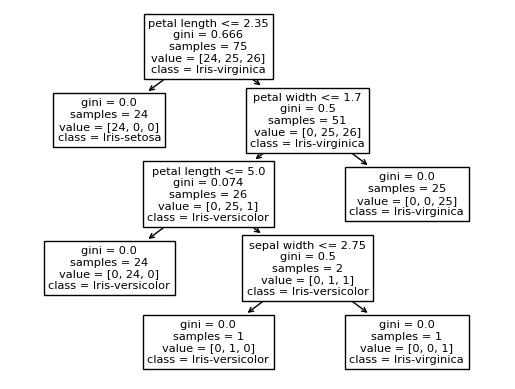

In [ ]:
model = tree.DecisionTreeClassifier()

model.fit(x_train50, y_train50.to_numpy().ravel())

model_pred = model.predict(x_test50)

print(confusion_matrix(y_test50, model_pred))
print(classification_report(y_test50, model_pred))

tree.plot_tree(model, feature_names = iris.data.headers, class_names = np.unique(y))

iris_tree_5050 = Classifier('Decision Tree 50/50', accuracy_score(y_test50, model_pred), confusion_matrix(y_test50, model_pred), classification_report(y_test50, model_pred))

**80 / 20 split**

[[10  0  0]
 [ 0  8  1]
 [ 0  3  8]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.73      0.89      0.80         9
 Iris-virginica       0.89      0.73      0.80        11

       accuracy                           0.87        30
      macro avg       0.87      0.87      0.87        30
   weighted avg       0.88      0.87      0.87        30



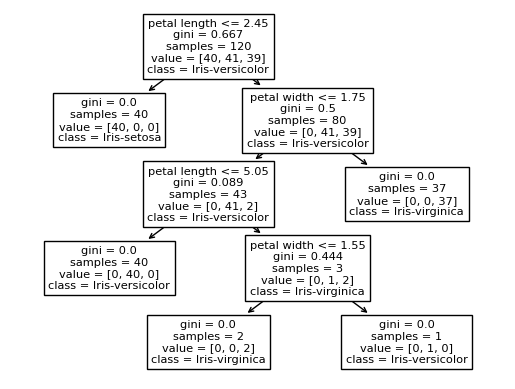

In [ ]:
model = tree.DecisionTreeClassifier()

model.fit(x_train80, y_train80.to_numpy().ravel())

model_pred = model.predict(x_test20)

print(confusion_matrix(y_test20, model_pred))
print(classification_report(y_test20, model_pred))

tree.plot_tree(model, feature_names = iris.data.headers, class_names = np.unique(y))

iris_tree_8020 = Classifier('Decision Tree 80/20', accuracy_score(y_test20, model_pred), confusion_matrix(y_test20, model_pred), classification_report(y_test20, model_pred))

### Naive Bayes

**50 / 50 split**

In [ ]:
model = GaussianNB()

model.fit(x_train50, y_train50.to_numpy().ravel())

model_pred = model.predict(x_test50)

print(confusion_matrix(y_test50, model_pred))
print(classification_report(y_test50, model_pred))

iris_bayes_5050 = Classifier('Naïve-Bayes 50/50', accuracy_score(y_test50, model_pred), confusion_matrix(y_test50, model_pred), classification_report(y_test50, model_pred))

[[26  0  0]
 [ 0 22  3]
 [ 0  3 21]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        26
Iris-versicolor       0.88      0.88      0.88        25
 Iris-virginica       0.88      0.88      0.88        24

       accuracy                           0.92        75
      macro avg       0.92      0.92      0.92        75
   weighted avg       0.92      0.92      0.92        75



**80 / 20 split**

In [ ]:
model = GaussianNB()

model.fit(x_train80, y_train80.to_numpy().ravel())

model_pred = model.predict(x_test20)

print(confusion_matrix(y_test20, model_pred))
print(classification_report(y_test20, model_pred))

iris_bayes_8020 = Classifier('Naïve-Bayes 80/20', accuracy_score(y_test20, model_pred), confusion_matrix(y_test20, model_pred), classification_report(y_test20, model_pred))

[[10  0  0]
 [ 0  7  2]
 [ 0  2  9]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.78      0.78      0.78         9
 Iris-virginica       0.82      0.82      0.82        11

       accuracy                           0.87        30
      macro avg       0.87      0.87      0.87        30
   weighted avg       0.87      0.87      0.87        30



### K-nearest neighbors

**Visualization**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


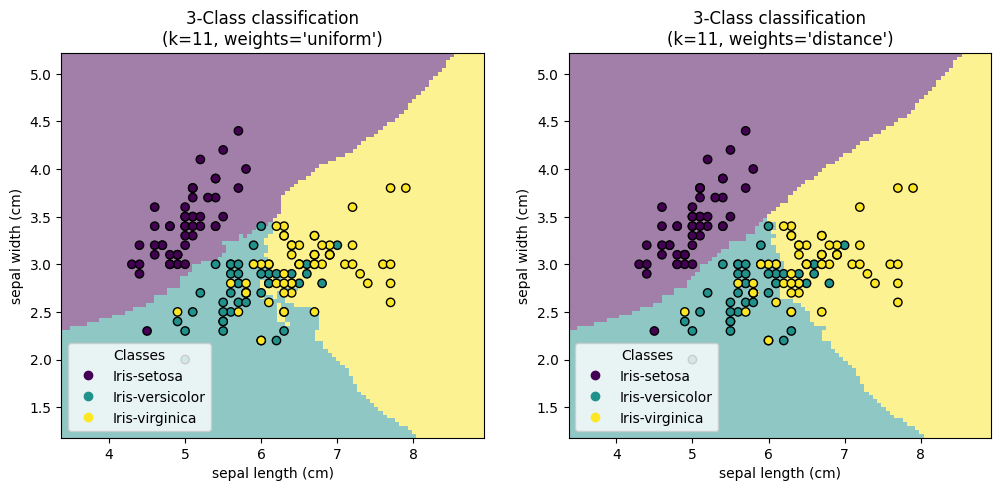

In [ ]:
# taken from https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py

x_trainvis = x_train50[['sepal length', 'sepal width']]
y_trainvis = y_train50

x_testvis = x_test50[['sepal length', 'sepal width']]
y_testvis = y_test50

label_encoder = LabelEncoder()
colors = label_encoder.fit_transform(y)

iris_knearest_vis = Pipeline(
    steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=11))]
)

_, axs = plt.subplots(ncols=2, figsize=(12, 5))

for ax, weights in zip(axs, ("uniform", "distance")):
    iris_knearest_vis.set_params(knn__weights=weights).fit(x_trainvis, y_trainvis.to_numpy().ravel())
    disp = DecisionBoundaryDisplay.from_estimator(
        iris_knearest_vis,
        x_testvis,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel="sepal length (cm)",
        ylabel="sepal width (cm)",
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(X.iloc[:, 0], X.iloc[:, 1], c=colors, edgecolors="k")
    disp.ax_.legend(
        scatter.legend_elements()[0],
        np.unique(y),
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"3-Class classification\n(k={iris_knearest_vis[-1].n_neighbors}, weights={weights!r})"
    )

plt.show()

**50/50 Split**

In [ ]:
model_pred = None
best_accuracy = -1
best_k = 0

for k in range(1, len(x_test50)):

    k_model = Pipeline(
        steps=[("scaler", StandardScaler()), ('knn', KNeighborsClassifier(k, weights = 'distance'))]
        # steps=[('knn', KNeighborsClassifier(k, weights = 'distance'))]
    )

    k_model.fit(x_train50, y_train50.to_numpy().ravel())

    k_model_pred = k_model.predict(x_test50)

    k_accuracy = accuracy_score(y_test50, k_model_pred)

    # print(f'> k({k}) accuracy: {k_accuracy}')

    if best_accuracy < k_accuracy:
        best_accuracy = k_accuracy
        model_pred = k_model_pred
        best_k = k

print()
print(f'> best k: {best_k}')
print(confusion_matrix(y_test50, model_pred))
print(classification_report(y_test50, model_pred))

iris_k_neighbors_5050 = Classifier(f'k({best_k})-neighbors 50/50', accuracy_score(y_test50, model_pred), confusion_matrix(y_test50, model_pred), classification_report(y_test50, model_pred))


> best k: 1
[[25  1  0]
 [ 0 25  0]
 [ 0  3 21]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      0.96      0.98        26
Iris-versicolor       0.86      1.00      0.93        25
 Iris-virginica       1.00      0.88      0.93        24

       accuracy                           0.95        75
      macro avg       0.95      0.95      0.95        75
   weighted avg       0.95      0.95      0.95        75



**80/20 Split**

In [ ]:
model_pred = None
best_accuracy = -1
best_k = 0

for k in range(1, len(x_test20)):

    k_model = Pipeline(
        steps=[("scaler", StandardScaler()), ('knn', KNeighborsClassifier(k, weights = 'distance'))]
        # steps=[('knn', KNeighborsClassifier(k, weights = 'distance'))]
    )

    k_model.fit(x_train80, y_train80.to_numpy().ravel())

    k_model_pred = k_model.predict(x_test20)

    k_accuracy = accuracy_score(y_test20, k_model_pred)

    # print(f'> k({k}) accuracy: {k_accuracy}')

    if best_accuracy < k_accuracy:
        best_accuracy = k_accuracy
        model_pred = k_model_pred
        best_k = k

print()
print(f'> best k: {best_k}')
print(confusion_matrix(y_test20, model_pred))
print(classification_report(y_test20, model_pred))

iris_k_neighbors_8020 = Classifier(f'k({best_k})-neighbors 80/20', accuracy_score(y_test20, model_pred), confusion_matrix(y_test20, model_pred), classification_report(y_test20, model_pred))


> best k: 5
[[10  0  0]
 [ 0  9  0]
 [ 0  2  9]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.82      1.00      0.90         9
 Iris-virginica       1.00      0.82      0.90        11

       accuracy                           0.93        30
      macro avg       0.94      0.94      0.93        30
   weighted avg       0.95      0.93      0.93        30



### SVM (Linear kernel)

**50/50 Split**

In [ ]:
model = svm.SVC(kernel = 'linear', C = 1.0)

model.fit(x_train50, y_train50.to_numpy().ravel())

model_pred = model.predict(x_test50)

print(confusion_matrix(y_test50, model_pred))
print(classification_report(y_test50, model_pred))

iris_SVM_linear_5050 = Classifier('SVM (linear) 50/50', accuracy_score(y_test50, model_pred), confusion_matrix(y_test50, model_pred), classification_report(y_test50, model_pred))

[[26  0  0]
 [ 0 24  1]
 [ 0  3 21]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        26
Iris-versicolor       0.89      0.96      0.92        25
 Iris-virginica       0.95      0.88      0.91        24

       accuracy                           0.95        75
      macro avg       0.95      0.94      0.95        75
   weighted avg       0.95      0.95      0.95        75



**80/20 Split**

In [ ]:
model = svm.SVC(kernel = 'linear', C = 1.0)

model.fit(x_train80, y_train80.to_numpy().ravel())

model_pred = model.predict(x_test20)

print(confusion_matrix(y_test20, model_pred))
print(classification_report(y_test20, model_pred))

iris_SVM_linear_8020 = Classifier('SVM (linear) 80/20', accuracy_score(y_test20, model_pred), confusion_matrix(y_test20, model_pred), classification_report(y_test20, model_pred))

[[10  0  0]
 [ 0  8  1]
 [ 0  1 10]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.89      0.89      0.89         9
 Iris-virginica       0.91      0.91      0.91        11

       accuracy                           0.93        30
      macro avg       0.93      0.93      0.93        30
   weighted avg       0.93      0.93      0.93        30



### SVM (rbf kernel)

**50/50 split**

In [ ]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.5, random_state = seed)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y.to_numpy().ravel())

best_C = grid.best_params_['C']
best_gamma = grid.best_params_['gamma']

print(f'best params c:{best_C}, gamma: {best_gamma}')

model = svm.SVC(C = best_C, gamma = best_gamma)

model.fit(x_train50, y_train50.to_numpy().ravel())

model_pred = model.predict(x_test50)

print(confusion_matrix(y_test50, model_pred))
print(classification_report(y_test50, model_pred))

iris_SVM_rbf_5050 = Classifier('SVM (rbf) 50/50', accuracy_score(y_test50, model_pred), confusion_matrix(y_test50, model_pred), classification_report(y_test50, model_pred))

best params c:1.0, gamma: 1.0
[[26  0  0]
 [ 0 23  2]
 [ 0  2 22]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        26
Iris-versicolor       0.92      0.92      0.92        25
 Iris-virginica       0.92      0.92      0.92        24

       accuracy                           0.95        75
      macro avg       0.95      0.95      0.95        75
   weighted avg       0.95      0.95      0.95        75



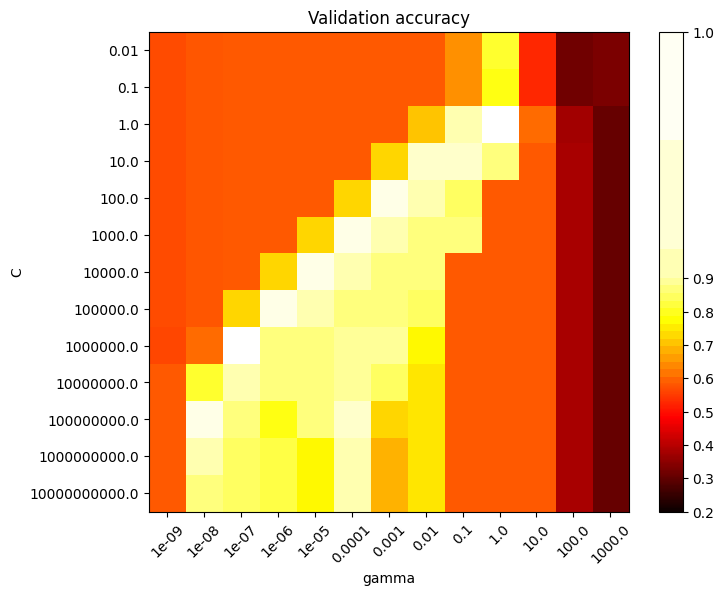

In [ ]:
scores = grid.cv_results_["mean_test_score"].reshape(len(C_range), len(gamma_range))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.hot,
    norm=MidpointNormalize(vmin=0.2, midpoint=0.92),
)
plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title("Validation accuracy")
plt.show()

**80/20 Split**

In [ ]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = seed)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y.to_numpy().ravel())

best_C = grid.best_params_['C']
best_gamma = grid.best_params_['gamma']

print(f'best params c:{best_C}, gamma: {best_gamma}')

model = svm.SVC(C = best_C, gamma = best_gamma)

model.fit(x_train50, y_train50.to_numpy().ravel())

model_pred = model.predict(x_test50)

print(confusion_matrix(y_test50, model_pred))
print(classification_report(y_test50, model_pred))

iris_SVM_rbf_8020 = Classifier('SVM (rbf) 80/20', accuracy_score(y_test50, model_pred), confusion_matrix(y_test50, model_pred), classification_report(y_test50, model_pred))

best params c:100.0, gamma: 0.01
[[26  0  0]
 [ 0 23  2]
 [ 0  2 22]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        26
Iris-versicolor       0.92      0.92      0.92        25
 Iris-virginica       0.92      0.92      0.92        24

       accuracy                           0.95        75
      macro avg       0.95      0.95      0.95        75
   weighted avg       0.95      0.95      0.95        75



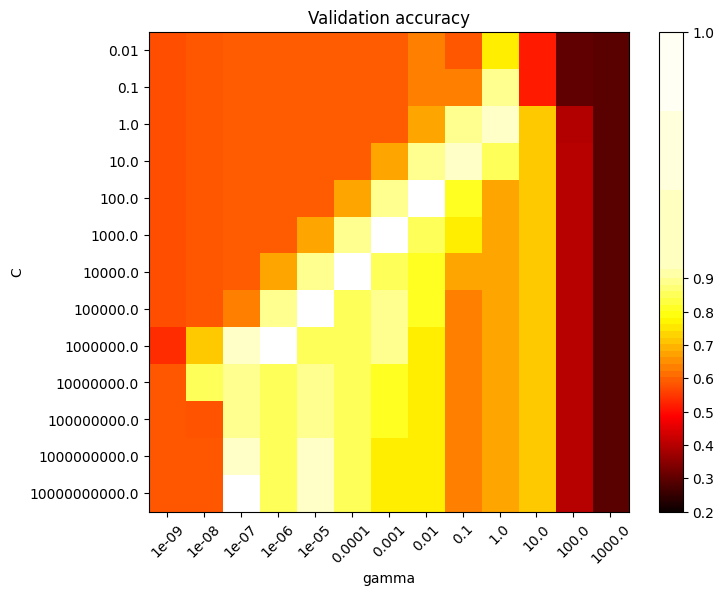

In [ ]:
scores = grid.cv_results_["mean_test_score"].reshape(len(C_range), len(gamma_range))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.hot,
    norm=MidpointNormalize(vmin=0.2, midpoint=0.92),
)
plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title("Validation accuracy")
plt.show()

### DNN


In [ ]:
input_size = X.shape[1]
output_size = 3

#preprocessing
label_encoder = LabelEncoder()
scaler = StandardScaler()

**50/50 Split**

In [ ]:
# preprocessing
y_train50_ord = label_encoder.fit_transform(y_train50) # can't use string as before -> assign unique integer to each class
y_test50_ord = label_encoder.fit_transform(y_test50)
x_train50_scaled = scaler.fit_transform(x_train50) # scale data to unit variance -> better results
x_test50_scaled = scaler.fit_transform(x_test50)

# define model

model = Sequential([
    Dense(64, activation='relu', input_shape=(input_size,)),
    Dense(64, activation='relu'),
    Dense(output_size, activation='softmax')
])

model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# training and testing

model.fit(x_train50_scaled, y_train50_ord, epochs=200, batch_size=64, verbose=2)

print()
print('Classification results:')

loss, accuracy = model.evaluate(x_test50_scaled, y_test50_ord, verbose=2)

model_pred = model.predict(x_test50_scaled)

# print(model_pred)

model_pred_classes = np.argmax(model_pred, axis=1)

print(confusion_matrix(y_test50_ord, model_pred_classes))
print(classification_report(y_test50_ord, model_pred_classes))

iris_DNN_5050 = Classifier('DNN [in 64 64 out]', accuracy, confusion_matrix(y_test50_ord, model_pred_classes), classification_report(y_test50_ord, model_pred_classes))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                320       
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                                 
 dense_18 (Dense)            (None, 3)                 195       
                                                                 
Total params: 4675 (18.26 KB)
Trainable params: 4675 (18.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/200
2/2 - 2s - loss: 1.1210 - accuracy: 0.2400 - 2s/epoch - 859ms/step
Epoch 2/200
2/2 - 0s - loss: 1.0487 - accuracy: 0.4000 - 17ms/epoch - 8ms/step
Epoch 3/200
2/2 - 0s - loss: 0.9818 - accuracy: 0.6400 - 35ms/epoch - 18ms/step
Epoch 4/200
2/2 - 0s - loss: 0.9187 - accuracy: 0.7867 - 17ms/epoch - 8ms/step
Epoch 5/200
2/2 - 0s - loss: 0.8616 - accuracy: 0.8133 - 20ms/epoch - 10ms/step
Epoch 6/200
2/2 - 0s - loss: 0.8097 - accuracy: 0.8133 - 45ms/epoch - 23ms/step
Epoch 7/200
2/2 - 0s - loss: 0.7598 - accuracy: 0.8267 - 29ms/epoch - 15ms/step
Epoch 8/200
2/2 - 0s - loss: 0.7147 - accuracy: 0.8267 - 22ms/epoch - 11ms/step
Epoch 9/200
2/2 - 0s - loss: 0.6741 - accuracy: 0.8267 - 30ms/epoch - 15ms/step
Epoch 10/200
2/2 - 0s - loss: 0.6356 - accuracy: 0.8400 - 19ms/epoch - 9ms/step
Epoch 11/200
2/2 - 0s - loss: 0.6016 - accuracy: 0.8400 - 20ms/epoch - 10ms/step
Epoch 12/200
2/2 - 0s - loss: 0.5709 - accuracy: 0.8400 - 20ms/epoch - 10ms/step
Epoch 13/200
2/2 - 0s - loss: 0.5420 - ac

In [ ]:
# preprocessing
y_train80_ord = label_encoder.fit_transform(y_train80) # can't use string as before -> assign unique integer to each class
y_test20_ord = label_encoder.fit_transform(y_test20)
x_train80_scaled = scaler.fit_transform(x_train80) # scale data to unit variance -> better results
x_test20_scaled = scaler.fit_transform(x_test20)

# define model

model = Sequential([
    Dense(64, activation='relu', input_shape=(input_size,)),
    Dense(64, activation='relu'),
    Dense(output_size, activation='softmax')
])

model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# training and testing

model.fit(x_train80_scaled, y_train80_ord, epochs=200, batch_size=64, verbose=2)

print()
print('Classification results:')

loss, accuracy = model.evaluate(x_test20_scaled, y_test20_ord, verbose=2)

model_pred = model.predict(x_test20_scaled)

# print(model_pred)

model_pred_classes = np.argmax(model_pred, axis=1)

print(confusion_matrix(y_test20_ord, model_pred_classes))
print(classification_report(y_test20_ord, model_pred_classes))

iris_DNN_8020 = Classifier('DNN [in 64 64 out]', accuracy, confusion_matrix(y_test20_ord, model_pred_classes), classification_report(y_test20_ord, model_pred_classes))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 64)                320       
                                                                 
 dense_20 (Dense)            (None, 64)                4160      
                                                                 
 dense_21 (Dense)            (None, 3)                 195       
                                                                 
Total params: 4675 (18.26 KB)
Trainable params: 4675 (18.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/200
2/2 - 2s - loss: 1.0856 - accuracy: 0.3667 - 2s/epoch - 810ms/step
Epoch 2/200
2/2 - 0s - loss: 1.0240 - accuracy: 0.5417 - 9ms/epoch - 5ms/step
Epoch 3/200
2/2 - 0s - loss: 0.9676 - accuracy: 0.7000 - 9ms/epoch - 4ms/step
Epoch 4/200
2/2 - 0s - loss: 0.9166 - accuracy: 0.7750 - 15ms/epoch - 7ms/step
Epoch 5/200
2/2 - 0s - loss: 0.8697 - accuracy: 0.8000 - 12ms/epoch - 6ms/step
Epoch 6/200
2/2 - 0s - loss: 0.8251 - accuracy: 0.8500 - 11ms/epoch - 5ms/step
Epoch 7/200
2/2 - 0s - loss: 0.7829 - accuracy: 0.8417 - 10ms/epoch - 5ms/step
Epoch 8/200
2/2 - 0s - loss: 0.7435 - accuracy: 0.8417 - 10ms/epoch - 5ms/step
Epoch 9/200
2/2 - 0s - loss: 0.7055 - accuracy: 0.8417 - 10ms/epoch - 5ms/step
Epoch 10/200
2/2 - 0s - loss: 0.6698 - accuracy: 0.8417 - 10ms/epoch - 5ms/step
Epoch 11/200
2/2 - 0s - loss: 0.6355 - accuracy: 0.8500 - 10ms/epoch - 5ms/step
Epoch 12/200
2/2 - 0s - loss: 0.6038 - accuracy: 0.8500 - 9ms/epoch - 5ms/step
Epoch 13/200
2/2 - 0s - loss: 0.5744 - accuracy: 0.8

### CNN

In [ ]:
input_size = X.shape[1]
output_size = 3

#preprocessing
label_encoder = LabelEncoder()

**50/50 Split**

In [ ]:
# preprocessing
y_train50_ord = label_encoder.fit_transform(y_train50) # can't use string as before -> assign unique integer to each class
y_test50_ord = label_encoder.fit_transform(y_test50)

x_train50_reshaped = x_train50.to_numpy().reshape(-1, input_size, 1)
x_test50_reshaped = x_test50.to_numpy().reshape(-1, input_size, 1)

# define model

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(input_size, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(output_size, activation='softmax')
])

model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# training and testing

model.fit(x_train50_reshaped, y_train50_ord, epochs=200, batch_size=64, verbose=2)

print()
print('Classification results:')

loss, accuracy = model.evaluate(x_test50_reshaped, y_test50_ord, verbose=2)

model_pred = model.predict(x_test50_reshaped)

# print(model_pred)

model_pred_classes = np.argmax(model_pred, axis=1)

print(confusion_matrix(y_test50_ord, model_pred_classes))
print(classification_report(y_test50_ord, model_pred_classes))

iris_CNN_5050 = Classifier('CNN [in C1D P1D F 128 out]', accuracy, confusion_matrix(y_test50_ord, model_pred_classes), classification_report(y_test50_ord, model_pred_classes))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 2, 64)             256       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 128)               8320      
                                                                 
 dense_23 (Dense)            (None, 3)                 387       
                                                                 
Total params: 8963 (35.01 KB)
Trainable params: 8963 (35.01 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/200
2/2 - 1s - loss: 1.3031 - accuracy: 0.2000 - 1s/epoch - 561ms/step
Epoch 2/200
2/2 - 0s - loss: 1.1402 - accuracy: 0.3333 - 14ms/epoch - 7ms/step
Epoch 3/200
2/2 - 0s - loss: 1.0214 - accuracy: 0.3333 - 14ms/epoch - 7ms/step
Epoch 4/200
2/2 - 0s - loss: 0.9513 - accuracy: 0.6000 - 16ms/epoch - 8ms/step
Epoch 5/200
2/2 - 0s - loss: 0.9194 - accuracy: 0.5200 - 13ms/epoch - 7ms/step
Epoch 6/200
2/2 - 0s - loss: 0.9027 - accuracy: 0.5867 - 15ms/epoch - 7ms/step
Epoch 7/200
2/2 - 0s - loss: 0.8867 - accuracy: 0.5333 - 17ms/epoch - 8ms/step
Epoch 8/200
2/2 - 0s - loss: 0.8642 - accuracy: 0.6667 - 17ms/epoch - 9ms/step
Epoch 9/200
2/2 - 0s - loss: 0.8396 - accuracy: 0.6667 - 19ms/epoch - 10ms/step
Epoch 10/200
2/2 - 0s - loss: 0.8075 - accuracy: 0.6667 - 17ms/epoch - 9ms/step
Epoch 11/200
2/2 - 0s - loss: 0.7748 - accuracy: 0.6667 - 14ms/epoch - 7ms/step
Epoch 12/200
2/2 - 0s - loss: 0.7449 - accuracy: 0.6667 - 14ms/epoch - 7ms/step
Epoch 13/200
2/2 - 0s - loss: 0.7181 - accuracy:

**80/20 Split**

In [ ]:
# preprocessing
y_train80_ord = label_encoder.fit_transform(y_train80) # can't use string as before -> assign unique integer to each class
y_test20_ord = label_encoder.fit_transform(y_test20)

x_train80_reshaped = x_train80.to_numpy().reshape(-1, input_size, 1)
x_test20_reshaped = x_test20.to_numpy().reshape(-1, input_size, 1)

# define model

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(input_size, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(output_size, activation='softmax')
])

model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# training and testing

model.fit(x_train80_reshaped, y_train80_ord, epochs=200, batch_size=64, verbose=2)

print()
print('Classification results:')

loss, accuracy = model.evaluate(x_test20_reshaped, y_test20_ord, verbose=2)

model_pred = model.predict(x_test20_reshaped)

# print(model_pred)

model_pred_classes = np.argmax(model_pred, axis=1)

print(confusion_matrix(y_test20_ord, model_pred_classes))
print(classification_report(y_test20_ord, model_pred_classes))

iris_CNN_8020 = Classifier('CNN [in C1D P1D F 128 out]', accuracy, confusion_matrix(y_test20_ord, model_pred_classes), classification_report(y_test20_ord, model_pred_classes))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 2, 64)             256       
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 dense_24 (Dense)            (None, 128)               8320      
                                                                 
 dense_25 (Dense)            (None, 3)                 387       
                                                                 
Total params: 8963 (35.01 KB)
Trainable params: 8963 (35.01 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/200
2/2 - 1s - loss: 1.4838 - accuracy: 0.3417 - 806ms/epoch - 403ms/step
Epoch 2/200
2/2 - 0s - loss: 1.3167 - accuracy: 0.3417 - 12ms/epoch - 6ms/step
Epoch 3/200
2/2 - 0s - loss: 1.1798 - accuracy: 0.3417 - 10ms/epoch - 5ms/step
Epoch 4/200
2/2 - 0s - loss: 1.0947 - accuracy: 0.3417 - 11ms/epoch - 6ms/step
Epoch 5/200
2/2 - 0s - loss: 1.0169 - accuracy: 0.5083 - 12ms/epoch - 6ms/step
Epoch 6/200
2/2 - 0s - loss: 0.9834 - accuracy: 0.6500 - 11ms/epoch - 6ms/step
Epoch 7/200
2/2 - 0s - loss: 0.9611 - accuracy: 0.4667 - 13ms/epoch - 7ms/step
Epoch 8/200
2/2 - 0s - loss: 0.9399 - accuracy: 0.4917 - 14ms/epoch - 7ms/step
Epoch 9/200
2/2 - 0s - loss: 0.9171 - accuracy: 0.6083 - 12ms/epoch - 6ms/step
Epoch 10/200
2/2 - 0s - loss: 0.8910 - accuracy: 0.6583 - 12ms/epoch - 6ms/step
Epoch 11/200
2/2 - 0s - loss: 0.8612 - accuracy: 0.6583 - 13ms/epoch - 6ms/step
Epoch 12/200
2/2 - 0s - loss: 0.8313 - accuracy: 0.6583 - 17ms/epoch - 8ms/step
Epoch 13/200
2/2 - 0s - loss: 0.8035 - accurac

## **Wine Dataset**

The Wine dataset (1991) contains the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of the three types of wine. In total, there are 178 instances, each belonging to one of three different classes of wine.

In [ ]:
wine = fetch_ucirepo(id=109)

# data (as pandas dataframes)
X = wine.data.features
y = wine.data.targets

In [ ]:
# metadata
wine.metadata

{'uci_id': 109,
 'name': 'Wine',
 'repository_url': 'https://archive.ics.uci.edu/dataset/109/wine',
 'data_url': 'https://archive.ics.uci.edu/static/public/109/data.csv',
 'abstract': 'Using chemical analysis to determine the origin of wines',
 'area': 'Physics and Chemistry',
 'tasks': ['Classification'],
 'characteristics': ['Tabular'],
 'num_instances': 178,
 'num_features': 13,
 'feature_types': ['Integer', 'Real'],
 'demographics': [],
 'target_col': ['class'],
 'index_col': None,
 'has_missing_values': 'no',
 'missing_values_symbol': None,
 'year_of_dataset_creation': 1992,
 'last_updated': 'Mon Aug 28 2023',
 'dataset_doi': '10.24432/C5PC7J',
 'creators': ['Stefan Aeberhard', 'M. Forina'],
 'intro_paper': {'title': 'Comparative analysis of statistical pattern recognition methods in high dimensional settings',
  'authors': 'S. Aeberhard, D. Coomans, O. Vel',
  'published_in': 'Pattern Recognition',
  'year': 1994,
  'url': 'https://www.semanticscholar.org/paper/83dc3e4030d7b9fbdb

In [ ]:
# variable information
wine.variables

,name,role,type,demographic,description,units,missing_values
0,class,Target,Categorical,None,None,None,no
1,Alcohol,Feature,Continuous,None,None,None,no
2,Malicacid,Feature,Continuous,None,None,None,no
3,Ash,Feature,Continuous,None,None,None,no
4,Alcalinity_of_ash,Feature,Continuous,None,None,None,no
5,Magnesium,Feature,Integer,None,None,None,no
6,Total_phenols,Feature,Continuous,None,None,None,no
7,Flavanoids,Feature,Continuous,None,None,None,no
8,Nonflavanoid_phenols,Feature,Continuous,None,None,None,no
9,Proanthocyanins,Feature,Continuous,None,None,None,no


In [ ]:
X

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


In [ ]:
y

,class
0,1
1,1
2,1
3,1
4,1
...,...
173,3
174,3
175,3
176,3


In [ ]:
x_train50, x_test50, y_train50, y_test50 = train_test_split(X, y, test_size = 0.5, random_state = seed)
x_train80, x_test20, y_train80, y_test20 = train_test_split(X, y, test_size = 0.2, random_state = seed)

### Decision Tree

**50 / 50 split**

[[26  4  0]
 [ 0 33  3]
 [ 0  2 21]]
              precision    recall  f1-score   support

           1       1.00      0.87      0.93        30
           2       0.85      0.92      0.88        36
           3       0.88      0.91      0.89        23

    accuracy                           0.90        89
   macro avg       0.91      0.90      0.90        89
weighted avg       0.91      0.90      0.90        89



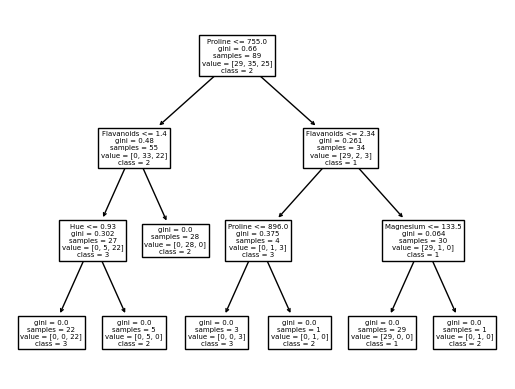

In [ ]:
model = tree.DecisionTreeClassifier()

model.fit(x_train50, y_train50.to_numpy().ravel())

model_pred = model.predict(x_test50)

print(confusion_matrix(y_test50, model_pred))
print(classification_report(y_test50, model_pred))

tree.plot_tree(model, feature_names = wine.data.headers, class_names = ['1', '2', '3'])

wine_tree_5050 = Classifier('Decision Tree 50/50', accuracy_score(y_test50, model_pred), confusion_matrix(y_test50, model_pred), classification_report(y_test50, model_pred))

**80 / 20 split**

[[ 9  2  0]
 [ 0 14  0]
 [ 0  1 10]]
              precision    recall  f1-score   support

           1       1.00      0.82      0.90        11
           2       0.82      1.00      0.90        14
           3       1.00      0.91      0.95        11

    accuracy                           0.92        36
   macro avg       0.94      0.91      0.92        36
weighted avg       0.93      0.92      0.92        36



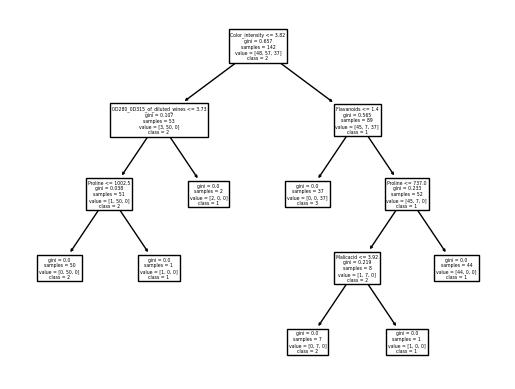

In [ ]:
model = tree.DecisionTreeClassifier()

model.fit(x_train80, y_train80.to_numpy().ravel())

model_pred = model.predict(x_test20)

print(confusion_matrix(y_test20, model_pred))
print(classification_report(y_test20, model_pred))

tree.plot_tree(model, feature_names = wine.data.headers, class_names = ['1', '2', '3'])

wine_tree_8020 = Classifier('Decision Tree 80/20', accuracy_score(y_test20, model_pred), confusion_matrix(y_test20, model_pred), classification_report(y_test20, model_pred))

### Naive Bayes

**50 / 50 split**

In [ ]:
model = GaussianNB()

model.fit(x_train50, y_train50.to_numpy().ravel())

model_pred = model.predict(x_test50)

print(confusion_matrix(y_test50, model_pred))
print(classification_report(y_test50, model_pred))

wine_bayes_5050 = Classifier('Naïve-Bayes 50/50', accuracy_score(y_test50, model_pred), confusion_matrix(y_test50, model_pred), classification_report(y_test50, model_pred))

[[28  2  0]
 [ 0 36  0]
 [ 0  1 22]]
              precision    recall  f1-score   support

           1       1.00      0.93      0.97        30
           2       0.92      1.00      0.96        36
           3       1.00      0.96      0.98        23

    accuracy                           0.97        89
   macro avg       0.97      0.96      0.97        89
weighted avg       0.97      0.97      0.97        89



**80 / 20 split**

In [ ]:
model = GaussianNB()

model.fit(x_train80, y_train80.to_numpy().ravel())

model_pred = model.predict(x_test20)

print(confusion_matrix(y_test20, model_pred))
print(classification_report(y_test20, model_pred))

wine_bayes_8020 = Classifier('Naïve-Bayes 80/20', accuracy_score(y_test20, model_pred), confusion_matrix(y_test20, model_pred), classification_report(y_test20, model_pred))

[[10  1  0]
 [ 0 14  0]
 [ 0  0 11]]
              precision    recall  f1-score   support

           1       1.00      0.91      0.95        11
           2       0.93      1.00      0.97        14
           3       1.00      1.00      1.00        11

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36



### K-nearest neighbors

**Visualization**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


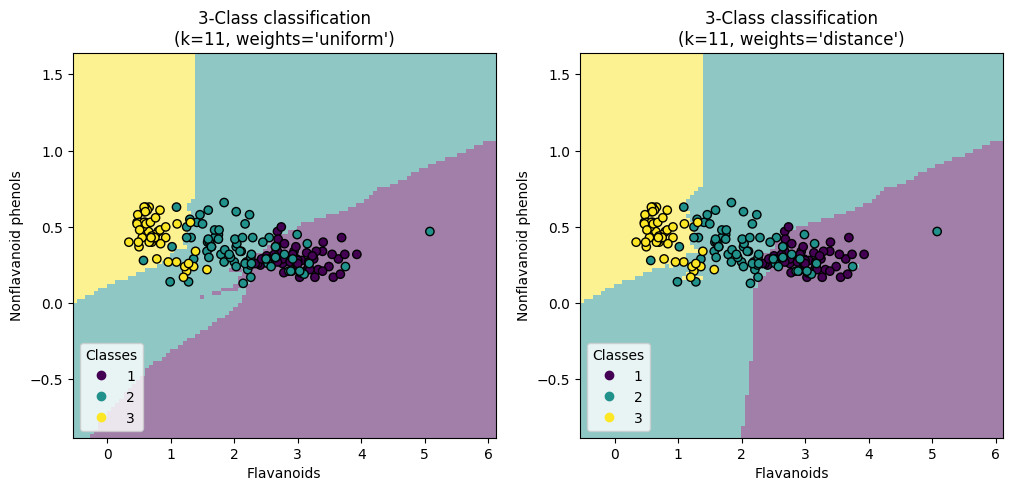

In [ ]:
# taken from https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py

x_trainvis = x_train50[['Flavanoids', 'Nonflavanoid_phenols']]
y_trainvis = y_train50

x_testvis = x_test50[['Flavanoids', 'Nonflavanoid_phenols']]
y_testvis = y_test50

label_encoder = LabelEncoder()
colors = label_encoder.fit_transform(y)

wine_knearest_vis = Pipeline(
    steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=11))]
)

_, axs = plt.subplots(ncols=2, figsize=(12, 5))

for ax, weights in zip(axs, ("uniform", "distance")):
    wine_knearest_vis.set_params(knn__weights=weights).fit(x_trainvis, y_trainvis.to_numpy().ravel())
    disp = DecisionBoundaryDisplay.from_estimator(
        wine_knearest_vis,
        x_testvis,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel="Flavanoids",
        ylabel="Nonflavanoid phenols",
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(X.iloc[:, 6], X.iloc[:, 7], c=colors, edgecolors="k")
    disp.ax_.legend(
        scatter.legend_elements()[0],
        ['1', '2', '3'],
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"3-Class classification\n(k={wine_knearest_vis[-1].n_neighbors}, weights={weights!r})"
    )

plt.show()

**50/50 Split**

In [ ]:
model_pred = None
best_accuracy = -1
best_k = 0

for k in range(1, len(x_test50)):

    k_model = Pipeline(
        steps=[("scaler", StandardScaler()), ('knn', KNeighborsClassifier(k, weights = 'distance'))]
        # steps=[('knn', KNeighborsClassifier(k, weights = 'distance'))]
    )

    k_model.fit(x_train50, y_train50.to_numpy().ravel())

    k_model_pred = k_model.predict(x_test50)

    k_accuracy = accuracy_score(y_test50, k_model_pred)

    # print(f'> k({k}) accuracy: {k_accuracy}')

    if best_accuracy < k_accuracy:
        best_accuracy = k_accuracy
        model_pred = k_model_pred
        best_k = k

print()
print(f'> best k: {best_k}')
print(confusion_matrix(y_test50, model_pred))
print(classification_report(y_test50, model_pred))

wine_k_neighbors_5050 = Classifier(f'k({best_k})-neighbors 50/50', accuracy_score(y_test50, model_pred), confusion_matrix(y_test50, model_pred), classification_report(y_test50, model_pred))


> best k: 48
[[30  0  0]
 [ 0 36  0]
 [ 0  0 23]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        30
           2       1.00      1.00      1.00        36
           3       1.00      1.00      1.00        23

    accuracy                           1.00        89
   macro avg       1.00      1.00      1.00        89
weighted avg       1.00      1.00      1.00        89



**80/20 Split**

In [ ]:
model_pred = None
best_accuracy = -1
best_k = 0

for k in range(1, len(x_test20)):

    k_model = Pipeline(
        steps=[("scaler", StandardScaler()), ('knn', KNeighborsClassifier(k, weights = 'distance'))]
        # steps=[('knn', KNeighborsClassifier(k, weights = 'distance'))]
    )

    k_model.fit(x_train80, y_train80.to_numpy().ravel())

    k_model_pred = k_model.predict(x_test20)

    k_accuracy = accuracy_score(y_test20, k_model_pred)

    # print(f'> k({k}) accuracy: {k_accuracy}')

    if best_accuracy < k_accuracy:
        best_accuracy = k_accuracy
        model_pred = k_model_pred
        best_k = k

print()
print(f'> best k: {best_k}')
print(confusion_matrix(y_test20, model_pred))
print(classification_report(y_test20, model_pred))

wine_k_neighbors_8020 = Classifier(f'k({best_k})-neighbors 80/20', accuracy_score(y_test20, model_pred), confusion_matrix(y_test20, model_pred), classification_report(y_test20, model_pred))


> best k: 21
[[11  0  0]
 [ 0 14  0]
 [ 0  0 11]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        11

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36




### SVM (linear kernel)

**50/50**

In [ ]:
model = svm.SVC(kernel = 'linear', C = 1.0)

model.fit(x_train50, y_train50.to_numpy().ravel())

model_pred = model.predict(x_test50)

print(confusion_matrix(y_test50, model_pred))
print(classification_report(y_test50, model_pred))

wine_SVM_linear_5050 = Classifier('SVM (linear) 50/50', accuracy_score(y_test50, model_pred), confusion_matrix(y_test50, model_pred), classification_report(y_test50, model_pred))

[[27  3  0]
 [ 1 34  1]
 [ 0  1 22]]
              precision    recall  f1-score   support

           1       0.96      0.90      0.93        30
           2       0.89      0.94      0.92        36
           3       0.96      0.96      0.96        23

    accuracy                           0.93        89
   macro avg       0.94      0.93      0.94        89
weighted avg       0.93      0.93      0.93        89



**80/20**

In [ ]:
model = svm.SVC(kernel = 'linear', C = 1.0)

model.fit(x_train80, y_train80.to_numpy().ravel())

model_pred = model.predict(x_test20)

print(confusion_matrix(y_test20, model_pred))
print(classification_report(y_test20, model_pred))

wine_SVM_linear_8020 = Classifier('SVM (linear) 80/20', accuracy_score(y_test20, model_pred), confusion_matrix(y_test20, model_pred), classification_report(y_test20, model_pred))

[[ 9  2  0]
 [ 0 14  0]
 [ 0  1 10]]
              precision    recall  f1-score   support

           1       1.00      0.82      0.90        11
           2       0.82      1.00      0.90        14
           3       1.00      0.91      0.95        11

    accuracy                           0.92        36
   macro avg       0.94      0.91      0.92        36
weighted avg       0.93      0.92      0.92        36



### SVM (rbf)

**50/50**

In [ ]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.5, random_state = seed)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y.to_numpy().ravel())

best_C = grid.best_params_['C']
best_gamma = grid.best_params_['gamma']

print(f'best params c:{best_C}, gamma: {best_gamma}')

model = svm.SVC(C = best_C, gamma = best_gamma)

model.fit(x_train50, y_train50.to_numpy().ravel())

model_pred = model.predict(x_test50)

print(confusion_matrix(y_test50, model_pred))
print(classification_report(y_test50, model_pred))

wine_SVM_rbf_5050 = Classifier('SVM (rbf) 50/50', accuracy_score(y_test50, model_pred), confusion_matrix(y_test50, model_pred), classification_report(y_test50, model_pred))

best params c:100000.0, gamma: 1e-06
[[27  3  0]
 [ 2 34  0]
 [ 0  1 22]]
              precision    recall  f1-score   support

           1       0.93      0.90      0.92        30
           2       0.89      0.94      0.92        36
           3       1.00      0.96      0.98        23

    accuracy                           0.93        89
   macro avg       0.94      0.93      0.94        89
weighted avg       0.93      0.93      0.93        89



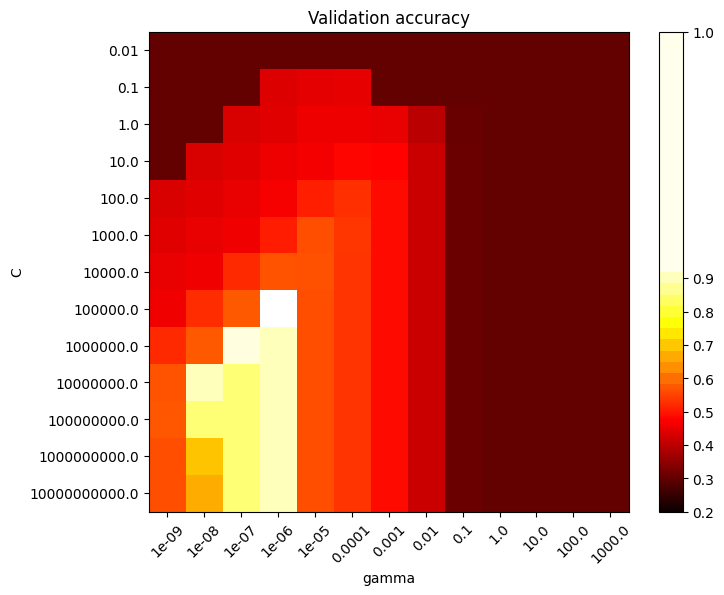

In [ ]:
scores = grid.cv_results_["mean_test_score"].reshape(len(C_range), len(gamma_range))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.hot,
    norm=MidpointNormalize(vmin=0.2, midpoint=0.92),
)
plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title("Validation accuracy")
plt.show()

**80/20**

In [ ]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = seed)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y.to_numpy().ravel())

best_C = grid.best_params_['C']
best_gamma = grid.best_params_['gamma']

print(f'best params c:{best_C}, gamma: {best_gamma}')

model = svm.SVC(C = best_C, gamma = best_gamma)

model.fit(x_train50, y_train50.to_numpy().ravel())

model_pred = model.predict(x_test50)

print(confusion_matrix(y_test50, model_pred))
print(classification_report(y_test50, model_pred))

wine_SVM_rbf_8020 = Classifier('SVM (rbf) 80/20', accuracy_score(y_test50, model_pred), confusion_matrix(y_test50, model_pred), classification_report(y_test50, model_pred))

best params c:10000000.0, gamma: 1e-08
[[27  3  0]
 [ 1 35  0]
 [ 0  1 22]]
              precision    recall  f1-score   support

           1       0.96      0.90      0.93        30
           2       0.90      0.97      0.93        36
           3       1.00      0.96      0.98        23

    accuracy                           0.94        89
   macro avg       0.95      0.94      0.95        89
weighted avg       0.95      0.94      0.94        89



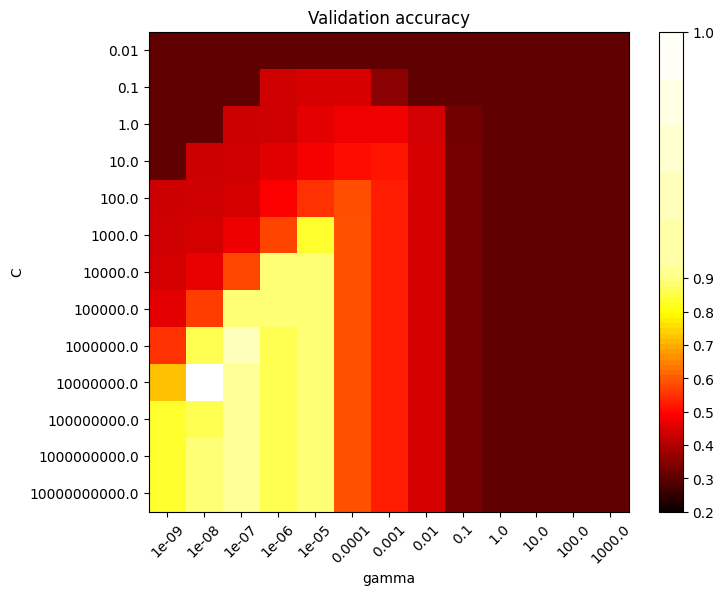

In [ ]:
scores = grid.cv_results_["mean_test_score"].reshape(len(C_range), len(gamma_range))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.hot,
    norm=MidpointNormalize(vmin=0.2, midpoint=0.92),
)
plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title("Validation accuracy")
plt.show()

### DNN

In [ ]:
input_size = X.shape[1]
output_size = 3

#preprocessing
label_encoder = LabelEncoder()
scaler = StandardScaler()

**50/50 Split**

In [ ]:
# preprocessing
y_train50_ord = label_encoder.fit_transform(y_train50) # can't use string as before -> assign unique integer to each class
y_test50_ord = label_encoder.fit_transform(y_test50)
x_train50_scaled = scaler.fit_transform(x_train50) # scale data to unit variance -> better results
x_test50_scaled = scaler.fit_transform(x_test50)

# define model

model = Sequential([
    Dense(64, activation='relu', input_shape=(input_size,)),
    Dense(64, activation='relu'),
    Dense(output_size, activation='softmax')
])

model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# training and testing

model.fit(x_train50_scaled, y_train50_ord, epochs=100, batch_size=64, verbose=2)

print()
print('Classification results:')

loss, accuracy = model.evaluate(x_test50_scaled, y_test50_ord, verbose=2)

model_pred = model.predict(x_test50_scaled)

# print(model_pred)

model_pred_classes = np.argmax(model_pred, axis=1)

print(confusion_matrix(y_test50_ord, model_pred_classes))
print(classification_report(y_test50_ord, model_pred_classes))

wine_DNN_5050 = Classifier('DNN [in 64 64 out]', accuracy, confusion_matrix(y_test50_ord, model_pred_classes), classification_report(y_test50_ord, model_pred_classes))

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 64)                896       
                                                                 
 dense_27 (Dense)            (None, 64)                4160      
                                                                 
 dense_28 (Dense)            (None, 3)                 195       
                                                                 
Total params: 5251 (20.51 KB)
Trainable params: 5251 (20.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2/2 - 1s - loss: 1.0642 - accuracy: 0.4270 - 736ms/epoch - 368ms/step
Epoch 2/100
2/2 - 0s - loss: 0.9545 - accuracy: 0.5955 - 12ms/epoch - 6ms/step
Epoch 3/100
2/2 - 0s - loss: 0.8616 - accuracy: 0.6854 - 10ms/epoch - 5ms/step
Epoch 4/100
2/2 - 0s - loss: 0.7771 - accuracy: 0.8202 - 10ms/epoch - 5ms/step
Epoch 5/100
2/2 - 0s - loss: 0.6988 - accuracy: 0.8876 - 11ms/epoch - 6ms/step
Epoch 6/100
2/2 - 0s - loss: 0.6278 - accuracy: 0.9326 - 10ms/epoch - 5ms/step
Epoch 7/100
2/2 - 0s - loss: 0.5643 - accuracy: 0.9438 - 9ms/epoch - 5ms/step
Epoch 8/100
2/2 - 0s - loss: 0.5054 - accuracy: 0.9438 - 11ms/epoch - 6ms/step
Epoch 9/100
2/2 - 0s - loss: 0.4530 - accuracy: 0.9775 - 10ms/epoch - 5ms/step
Epoch 10/100
2/2 - 0s - loss: 0.4053 - accuracy: 0.9775 - 10ms/epoch - 5ms/step
Epoch 11/100
2/2 - 0s - loss: 0.3642 - accuracy: 0.9775 - 10ms/epoch - 5ms/step
Epoch 12/100
2/2 - 0s - loss: 0.3266 - accuracy: 0.9775 - 12ms/epoch - 6ms/step
Epoch 13/100
2/2 - 0s - loss: 0.2941 - accuracy: 0.9775 - 1

**80/20 Split**

In [ ]:
# preprocessing
y_train80_ord = label_encoder.fit_transform(y_train80) # can't use string as before -> assign unique integer to each class
y_test20_ord = label_encoder.fit_transform(y_test20)
x_train80_scaled = scaler.fit_transform(x_train80) # scale data to unit variance -> better results
x_test20_scaled = scaler.fit_transform(x_test20)

# define model

model = Sequential([
    Dense(64, activation='relu', input_shape=(input_size,)),
    Dense(64, activation='relu'),
    Dense(output_size, activation='softmax')
])

model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# training and testing

model.fit(x_train80_scaled, y_train80_ord, epochs=100, batch_size=64, verbose=2)

print()
print('Classification results:')

loss, accuracy = model.evaluate(x_test20_scaled, y_test20_ord, verbose=2)

model_pred = model.predict(x_test20_scaled)

# print(model_pred)

model_pred_classes = np.argmax(model_pred, axis=1)

print(confusion_matrix(y_test20_ord, model_pred_classes))
print(classification_report(y_test20_ord, model_pred_classes))

wine_DNN_8020 = Classifier('DNN [in 64 64 out]', accuracy, confusion_matrix(y_test20_ord, model_pred_classes), classification_report(y_test20_ord, model_pred_classes))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 64)                896       
                                                                 
 dense_30 (Dense)            (None, 64)                4160      
                                                                 
 dense_31 (Dense)            (None, 3)                 195       
                                                                 
Total params: 5251 (20.51 KB)
Trainable params: 5251 (20.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
3/3 - 1s - loss: 1.2999 - accuracy: 0.0775 - 997ms/epoch - 332ms/step
Epoch 2/100
3/3 - 0s - loss: 1.1366 - accuracy: 0.2183 - 14ms/epoch - 5ms/step
Epoch 3/100
3/3 - 0s - loss: 1.0019 - accuracy: 0.6127 - 14ms/epoch - 5ms/step
Epoch 4/100
3/3 - 0s - loss: 0.8823 - accur

### CNN

In [ ]:
input_size = X.shape[1]
output_size = 3

#preprocessing
label_encoder = LabelEncoder()

13


**50/50 Split**

In [ ]:
# preprocessing
y_train50_ord = label_encoder.fit_transform(y_train50) # can't use string as before -> assign unique integer to each class
y_test50_ord = label_encoder.fit_transform(y_test50)

x_train50_reshaped = x_train50.to_numpy().reshape(-1, input_size, 1)
x_test50_reshaped = x_test50.to_numpy().reshape(-1, input_size, 1)

# define model

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(input_size, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(output_size, activation='softmax')
])

model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# training and testing

model.fit(x_train50_reshaped, y_train50_ord, epochs=200, batch_size=64, verbose=2)

print()
print('Classification results:')

loss, accuracy = model.evaluate(x_test50_reshaped, y_test50_ord, verbose=2)

model_pred = model.predict(x_test50_reshaped)

# print(model_pred)

model_pred_classes = np.argmax(model_pred, axis=1)

print(confusion_matrix(y_test50_ord, model_pred_classes))
print(classification_report(y_test50_ord, model_pred_classes))

wine_CNN_5050 = Classifier('CNN [in C1D P1D F 128 out]', accuracy, confusion_matrix(y_test50_ord, model_pred_classes), classification_report(y_test50_ord, model_pred_classes))

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 11, 64)            256       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 5, 64)             0         
 g1D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 320)               0         
                                                                 
 dense_32 (Dense)            (None, 128)               41088     
                                                                 
 dense_33 (Dense)            (None, 3)                 387       
                                                                 
Total params: 41731 (163.01 KB)
Trainable params: 41731 (163.01 KB)
Non-trainable params: 0 (0.00 Byte)
_______________

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/200
2/2 - 1s - loss: 1.8684 - accuracy: 0.4045 - 737ms/epoch - 368ms/step
Epoch 2/200
2/2 - 0s - loss: 1.1805 - accuracy: 0.4157 - 13ms/epoch - 6ms/step
Epoch 3/200
2/2 - 0s - loss: 1.5441 - accuracy: 0.5056 - 20ms/epoch - 10ms/step
Epoch 4/200
2/2 - 0s - loss: 1.0141 - accuracy: 0.5843 - 15ms/epoch - 7ms/step
Epoch 5/200
2/2 - 0s - loss: 1.0640 - accuracy: 0.3034 - 16ms/epoch - 8ms/step
Epoch 6/200
2/2 - 0s - loss: 0.7427 - accuracy: 0.7191 - 11ms/epoch - 5ms/step
Epoch 7/200
2/2 - 0s - loss: 0.9506 - accuracy: 0.6067 - 17ms/epoch - 9ms/step
Epoch 8/200
2/2 - 0s - loss: 0.7861 - accuracy: 0.6517 - 12ms/epoch - 6ms/step
Epoch 9/200
2/2 - 0s - loss: 0.6460 - accuracy: 0.8090 - 11ms/epoch - 5ms/step
Epoch 10/200
2/2 - 0s - loss: 0.8083 - accuracy: 0.4944 - 14ms/epoch - 7ms/step
Epoch 11/200
2/2 - 0s - loss: 0.5869 - accuracy: 0.8090 - 12ms/epoch - 6ms/step
Epoch 12/200
2/2 - 0s - loss: 0.6944 - accuracy: 0.6966 - 13ms/epoch - 6ms/step
Epoch 13/200
2/2 - 0s - loss: 0.6047 - accura

**80/20 Split**

In [ ]:
# preprocessing
y_train80_ord = label_encoder.fit_transform(y_train80) # can't use string as before -> assign unique integer to each class
y_test20_ord = label_encoder.fit_transform(y_test20)

x_train80_reshaped = x_train80.to_numpy().reshape(-1, input_size, 1)
x_test20_reshaped = x_test20.to_numpy().reshape(-1, input_size, 1)

# define model

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(input_size, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(output_size, activation='softmax')
])

model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# training and testing

model.fit(x_train80_reshaped, y_train80_ord, epochs=200, batch_size=64, verbose=2)

print()
print('Classification results:')

loss, accuracy = model.evaluate(x_test20_reshaped, y_test20_ord, verbose=2)

model_pred = model.predict(x_test20_reshaped)

# print(model_pred)

model_pred_classes = np.argmax(model_pred, axis=1)

print(confusion_matrix(y_test20_ord, model_pred_classes))
print(classification_report(y_test20_ord, model_pred_classes))

wine_CNN_8020 = Classifier('CNN [in C1D P1D F 128 out]', accuracy, confusion_matrix(y_test20_ord, model_pred_classes), classification_report(y_test20_ord, model_pred_classes))

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 11, 64)            256       
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 5, 64)             0         
 g1D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 320)               0         
                                                                 
 dense_34 (Dense)            (None, 128)               41088     
                                                                 
 dense_35 (Dense)            (None, 3)                 387       
                                                                 
Total params: 41731 (163.01 KB)
Trainable params: 41731 (163.01 KB)
Non-trainable params: 0 (0.00 Byte)
_______________

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


3/3 - 1s - loss: 4.3989 - accuracy: 0.4155 - 806ms/epoch - 269ms/step
Epoch 2/200
3/3 - 0s - loss: 1.8885 - accuracy: 0.2676 - 19ms/epoch - 6ms/step
Epoch 3/200
3/3 - 0s - loss: 1.3556 - accuracy: 0.4014 - 18ms/epoch - 6ms/step
Epoch 4/200
3/3 - 0s - loss: 1.4367 - accuracy: 0.3944 - 17ms/epoch - 6ms/step
Epoch 5/200
3/3 - 0s - loss: 1.3755 - accuracy: 0.5070 - 17ms/epoch - 6ms/step
Epoch 6/200
3/3 - 0s - loss: 0.9514 - accuracy: 0.6127 - 18ms/epoch - 6ms/step
Epoch 7/200
3/3 - 0s - loss: 0.9221 - accuracy: 0.5563 - 19ms/epoch - 6ms/step
Epoch 8/200
3/3 - 0s - loss: 1.0532 - accuracy: 0.4859 - 18ms/epoch - 6ms/step
Epoch 9/200
3/3 - 0s - loss: 0.7507 - accuracy: 0.7042 - 17ms/epoch - 6ms/step
Epoch 10/200
3/3 - 0s - loss: 0.6802 - accuracy: 0.7183 - 17ms/epoch - 6ms/step
Epoch 11/200
3/3 - 0s - loss: 0.6602 - accuracy: 0.8521 - 19ms/epoch - 6ms/step
Epoch 12/200
3/3 - 0s - loss: 0.6404 - accuracy: 0.6972 - 18ms/epoch - 6ms/step
Epoch 13/200
3/3 - 0s - loss: 0.6033 - accuracy: 0.7535 - 

## Results

The following tables contain the evaluation metrics for each of the models.

### Iris Dataset

**50/50 Split**

In [ ]:
models = [iris_tree_5050,
          iris_bayes_5050,
          iris_k_neighbors_5050,
          iris_SVM_linear_5050,
          iris_SVM_rbf_5050,
          iris_DNN_5050,
          iris_CNN_5050]

data = {
    'Model': [m.name for m in models],
    'Accuracy': [m.accuracy for m in models],
}

table_iris_5050 = pd.DataFrame(data)

In [ ]:
table_iris_5050

,Model,Accuracy
0,Decision Tree 50/50,0.946667
1,Naïve-Bayes 50/50,0.920000
2,k(1)-neighbors 50/50,0.946667
3,SVM (linear) 50/50,0.946667
4,SVM (rbf) 50/50,0.946667
5,DNN [in 64 64 out],0.933333
6,CNN [in C1D P1D F 128 out],0.960000


**80/20 Split**

In [ ]:
models = [iris_tree_8020,
          iris_bayes_8020,
          iris_k_neighbors_8020,
          iris_SVM_linear_8020,
          iris_SVM_rbf_8020,
          iris_DNN_8020,
          iris_CNN_8020]

data = {
    'Model': [m.name for m in models],
    'Accuracy': [m.accuracy for m in models],
}

table_iris_8020 = pd.DataFrame(data)

In [ ]:
table_iris_8020

,Model,Accuracy
0,Decision Tree 80/20,0.866667
1,Naïve-Bayes 80/20,0.866667
2,k(5)-neighbors 80/20,0.933333
3,SVM (linear) 80/20,0.933333
4,SVM (rbf) 80/20,0.946667
5,DNN [in 64 64 out],0.900000
6,CNN [in C1D P1D F 128 out],0.966667


### Wine Dataset

**50/50 Split**

In [ ]:
models = [wine_tree_5050,
          wine_bayes_5050,
          wine_k_neighbors_5050,
          wine_SVM_linear_5050,
          wine_SVM_rbf_5050,
          wine_DNN_5050,
          wine_CNN_5050]

data = {
    'Model': [m.name for m in models],
    'Accuracy': [m.accuracy for m in models],
}

table_wine_5050 = pd.DataFrame(data)

In [ ]:
table_wine_5050

,Model,Accuracy
0,Decision Tree 50/50,0.898876
1,Naïve-Bayes 50/50,0.966292
2,k(48)-neighbors 50/50,1.000000
3,SVM (linear) 50/50,0.932584
4,SVM (rbf) 50/50,0.932584
5,DNN [in 64 64 out],0.988764
6,CNN [in C1D P1D F 128 out],0.898876


**80/20 Split**

In [ ]:
models = [wine_tree_8020,
          wine_bayes_8020,
          wine_k_neighbors_8020,
          wine_SVM_linear_8020,
          wine_SVM_rbf_8020,
          wine_DNN_8020,
          wine_CNN_8020]

data = {
    'Model': [m.name for m in models],
    'Accuracy': [m.accuracy for m in models],
}

table_wine_8020 = pd.DataFrame(data)

In [ ]:
table_wine_8020

,Model,Accuracy
0,Decision Tree 80/20,0.916667
1,Naïve-Bayes 80/20,0.972222
2,k(21)-neighbors 80/20,1.000000
3,SVM (linear) 80/20,0.916667
4,SVM (rbf) 80/20,0.943820
5,DNN [in 64 64 out],0.972222
6,CNN [in C1D P1D F 128 out],0.888889


## **Conclusions**

Most of the classifiers had comparable results, scoring relatively highly in each of the
tests. In order to choose which algorithms one to use in future work, one should conduct tests using multiple approaches with different training and testing sampling techniques, since, as always, the algorithms are just the pawns while data is king.

Additionally, maybe by averaging the results over a set of tests, one could get more statistically significant results since the accuracy with the same split percentages varies between test runs. In future work, maybe performing 100 tests for each of the models using a defined set of 100 seeds, and computing the average performance, could yield better results.

On another note, the DNN results could still be improved by performing hyperparameter tuning methods, such as a grid search approach. However, just scaling the data beforehand yielded notable improvements.

Finally, CNNs are not really suited for these sorts of applications since both datasets do not contain spatial information and would not benefit from the core concepts of these architectures. This could explain the relatively low accuracy of the of the results.

## **References**

Aeberhard, S. & Forina, M. (1991). Wine. UCI Machine Learning Repository.
https://doi.org/10.24432/C5PC7J.

Cuevas, J. (2020). Handouts on Classification Algorithms. DOI:10.13140/RG.2.2.23597.03043/1.

Cuevas, J.,Valenzuela, M., and Nolazco, J. (2016b). A tutorial on deep neural networks for intelligent systems. DOI:10.13140/RG.2.1.2420.6481

Gunn, S. (1998). Support Vector Machines for Classification and Regression. University of Southampton.

Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep Learning. MIT Press. http://www.deeplearningbook.org.

Hastie, T., Tibshirani, R., Friedman, R. (2008). The Elements of
Statistical Learning: Data Mining, Inference, and Prediction. Springer.

Hinton et al. (2012). Deep Neural Networks for Acoustic Modeling in Speech Recognition. IEEE Signal Processing. DOI: 10.1109/MSP.2012.2205597

Fisher, R. A. (1988). Iris. UCI Machine Learning Repository. https://doi.org/10.24432/C56C76.

Russell, S. & Norvig, P. (2015). Artificial Intelligence: A Modern Approach, 3rd Edition. Pearson Education. ISBN: 978-0136042594.